# gonna use XGB now to combine the categorical, continuous and pre-embedded free text stuff

#### Online, we import the usual packages. **xgboost** needs to be installed (with conda install xgboost or pip install -U xgboost).

In [29]:
#!pip install xgboost

####  the usual imports

In [2]:
import pandas as pd
import numpy as np
import re
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics
from collections import Counter
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import sys
import random as rn
from IPython.display import clear_output
import pickle

### load helper functions

In [3]:
def thresholding_analysis(preds, targets, admission_thresholds = [0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]):

    i = 0
    for thresh in admission_thresholds:
        thresholded_predictions = [0 if prob[0] >= thresh else 1 for prob in preds]
        
        f1_w, f1, acc, prec, rec, auroc = get_metrics(targets,thresholded_predictions, print_output = False)

        if i == 0:
            output_df = pd.DataFrame([thresh, f1_w, f1, acc, prec, rec, rec[0], rec[1]]).T
            output_df.columns = ['admission_threshold', 'AUROC', 'f1', 'accuracy', 'precision', 'recall', 'admission sensitivity', 'admission specificity']
        else:
            output_df.loc[len(output_df)] = [thresh, auroc, f1, acc, prec, rec, rec[0], rec[1]]
        i+=1
    
    return output_df

In [295]:

def show_confusion_matrix2(confusion_matrix, labels):
    LABELS = labels

    plt.figure(figsize=(3, 3))
    sns.heatmap(confusion_matrix, cmap = 'Blues', xticklabels=LABELS, yticklabels=LABELS, annot=True, fmt="d", annot_kws={"size": 15});
    plt.title("Confusion matrix", fontsize=10)
    plt.ylabel('True label', fontsize=10)
    plt.xlabel('Predicted label', fontsize=10)
    plt.show()
    
def get_metrics(model, y_test, X_test, show_confusion = True, print_output = True, return_values = False):
    preds = model.predict_proba(X_test)
    predictions = model.predict(X_test)
    
    f1_w = sklearn.metrics.f1_score(y_test, predictions, average='weighted')
    f1 = sklearn.metrics.f1_score(y_test, predictions, average=None)
    acc = sklearn.metrics.accuracy_score(y_test, predictions)
    prec = sklearn.metrics.precision_score(y_test,predictions, average=None) 
    rec = sklearn.metrics.recall_score(y_test,predictions, average=None)
    auroc = sklearn.metrics.roc_auc_score(y_test,preds[:,1], average=None)
    confusion = sklearn.metrics.confusion_matrix(y_test, predictions)
    
    tn, fp, fn, tp = confusion[0,0], confusion[0,1], confusion[1,0], confusion[1,1]
    
    sens = tp/(tp + fn)
    spec = tn/(tn + fp)
    ppv = tp/(tp + fp)
    npv = tn/(tn + fn)
    
    
    if print_output:
        print ('Metrics Report:')
        print ('---------------')
        print ('weighted f1: ', f1_w)
        print ('AUROC:       ',auroc)
        print ('accuracy:    ', acc)
        print ('precision:   ', prec)
        print ('recall:      ', rec)
        #print ('admission sens: ', rec[0])
        #print ('admission spec: ', rec[1])
        print ('sensitivity: ', sens)
        print ('specificity: ', spec)
        print ('PPV:         ', ppv)
        print ('NPV:         ', npv)
        
    if show_confusion:
        show_confusion_matrix2(confusion, labels = ['d/c', 'admit'])
     
    if return_values == True:
        return f1_w, auroc, acc, sens, ppv




In [5]:
def JJ_gridsearch(weights, print_output = False):
    epoch = 0
    for weight in weights:
        
        xgc = xgb.XGBClassifier(scale_pos_weight=weight)
        xgc.fit(X_train, y_train)
        preds = xgc.predict(X_test)
        probas = xgc.predict_proba(X_test)
        f1_w, f1, acc, prec, rec = get_metrics(y_test, preds, print_output)
        
        if epoch == 0:
            results_df = pd.DataFrame([epoch+1, 1/weight, f1_w, f1, acc, prec, rec, rec[0], rec[1]]).T
            results_df.columns = ['trial number', 'class penalty', 'weighted f1', 'f1', 'accuracy', 'precision', 'recall', 'admission sensitivity', 'admission specificity']
        else:
            results_df.loc[len(results_df)] = [epoch+1, 1/weight, f1_w, f1, acc, prec, rec, rec[0], rec[1]]
        
        epoch +=1
        
    return xgc, results_df, preds, probas

In [73]:
def convert_dxcode(s):
    code = dx_code_dict[s]
    return (code)

In [6]:
#use this cell when working from home
path = '/Users/jjaskolkambp/Desktop/machine learning/my_projects/ed-triage'
data_path = '/Users/jjaskolkambp/Desktop/machine learning/my_projects/data/ED triage project/combo'
model_path = '/Users/jjaskolkambp/Desktop/machine learning/my_projects/ed-triage/models'

In [58]:
clin = pd.read_csv(data_path + '/complete_clean_combo_data.csv', index_col = 0,low_memory = False)

In [59]:
dx_code_dict = {code:i for i,code in enumerate(set(clin['MainDiagnosisCode']))}

def convert_dxcode(s):
    code = dx_code_dict[s]
    return (code)

clin['recoded_diagnosis'] = clin['MainDiagnosisCode'].map(convert_dxcode)

In [60]:
medhx = np.load(data_path + '/medhx_embeds.npy')

#this is the admit vs d/c target
target = np.load(data_path + '/admit_dc_target.npy')

subjnotes = np.load(data_path + '/subj_emeds.npy')


In [61]:
bch_data = clin[clin['site']== 'BCH']

In [62]:
bch_idxs = np.array(list(bch_data.index)); len(bch_idxs)

102128

In [63]:
medhx = medhx[bch_idxs]
subjnotes = subjnotes[bch_idxs]
target = target[bch_idxs]

In [64]:
clin = bch_data

In [65]:
clin.shape

(102128, 122)

In [14]:
#this cell will define the various groupings of variables from the dataframe
dx_vars = ['recoded_diagnosis', 'PresentingComplaint']

cont_vars = [ 'Triage Date & TimeYear', 'Triage Date & TimeMonth', 'Triage Date & TimeWeek', 'Triage Date & TimeDay',
 'Triage Date & TimeDayofweek', 'Triage Date & TimeDayofyear', 'Triage Date & TimeHour', 'Triage Date & TimeMinute',
 'Triage Date & TimeSecond', 'Triage Date & TimeElapsed',
 'num_comorbids','systolic', 'diastolic', 'o2sat', 'pulse', 'temp', 'AgeInYrs']


cos_date_vars = ['Triage Date & Timeweekday_cos',
       'Triage Date & Timeweekday_sin', 'Triage Date & Timeday_month_cos',
       'Triage Date & Timeday_month_sin', 'Triage Date & Timemonth_year_cos',
       'Triage Date & Timemonth_year_sin', 'Triage Date & Timeday_year_cos',
       'Triage Date & Timeday_year_sin', 'Triage Date & Timehour_cos',
       'Triage Date & Timehour_sin', 'Triage Date & Timeclock_cos',
       'Triage Date & Timeclock_sin', 'Triage Date & Timemin_cos',
       'Triage Date & Timemin_sin', 'Triage Date & Timesec_cos']

cat_vars = ['Triage Date & TimeIs_month_end',
 'Triage Date & TimeIs_month_start',
 'Triage Date & TimeIs_quarter_end',
 'Triage Date & TimeIs_quarter_start',
 'Triage Date & TimeIs_year_end',
 'Triage Date & TimeIs_year_start',
 'GenderDesc', 'TriageLevel', 'site']

inf_control_vars = ['Are you feeling feverish or have had shakes or chills in the last 24 hours?',
 'Have you ever been isolated/required isolation for an infectious disease when receiving care in a healthcare setting?',
 'Do you have a new Rash?',
 'Do you have a new onset of Vomiting/Diarrhea in the last 24 hours?',
 'Have you travelled outside of Canada/USA in the last 3 weeks?',
 'Have you had contact with a sick person who has travelled outside of Canada/USA in the last 3 weeks?',
 'Have you received Health Care in another country in the last 2 years?',
 'Do you have a new/worse cough or shortness of breath?',
 'If so, select all countries that apply',
 'If so, select all infectious diseases that apply']

### preprocessing variables to use in XGB

In [15]:
#need to preprocess cat vars for xgb
X = clin[cat_vars + inf_control_vars].values.astype(str)

features = []
for i in range(0, X.shape[1]):
    label_encoder = LabelEncoder()
    feature = label_encoder.fit_transform(X[:,i])
    features.append(feature)
encoded_x = np.array(features)
encoded_x = encoded_x.reshape(X.shape[0], X.shape[1])

In [16]:
encoded_x.shape

(102128, 19)

In [17]:
X2 = clin[dx_vars].values.astype(str)
encoded_x2 = None
for i in range(0, X2.shape[1]):
	label_encoder = LabelEncoder()
	feature = label_encoder.fit_transform(X2[:,i])
	feature = feature.reshape(X2.shape[0], 1)
	onehot_encoder = OneHotEncoder(sparse=False)
	feature = onehot_encoder.fit_transform(feature)
	if encoded_x2 is None:
		encoded_x2 = feature
	else:
		encoded_x2 = np.concatenate((encoded_x2, feature), axis=1)
print("X shape: : ", encoded_x2.shape)

X shape: :  (102128, 3292)


In [18]:
#splitting this one hot encoded matrix into one for the presenting complaint and one for the medical history
X_pres = encoded_x2[:,:169]

X_dx = encoded_x2[:,169:]

In [19]:
features = np.concatenate((encoded_x,X_pres, X_dx, clin[cont_vars].values), axis =1)

all_features = np.concatenate((features,subjnotes,medhx), axis = 1)
all_features.shape

(102128, 4864)

### dataset size analysis

In [25]:
       
dataset_sizes = [10000, 30000, 60000, 100000, 130000, len(clin)]    

#initialize dataframe for results
col_names = ['num_examples','train_f1', 'test_f1', 'train_acc', 'test_acc', 'train_auroc', 'test_auroc', 'train_ppv', 'test_ppv', 'train_sens', 'test_sens']
output_df = pd.DataFrame(columns = col_names)

for size in dataset_sizes:
    print ()
    print ('Training with {} examples'.format(size))
    print ()
    
    X_train, X_test, y_train, y_test = train_test_split(all_features[:size], target[:size], random_state=1)
    
    xgc = xgb.XGBClassifier(scale_pos_weight = 1/9, gamma = 0.5, reg_alpha = 0.5)
    %time xgc.fit(X_train, y_train)
    
    #random train subset for metrics
    random_indices = np.random.choice(X_test.shape[0], len(X_test), replace=False)
    
    print ('\nTraining Set')
    train_f1, train_auroc, train_acc, train_sens, train_ppv = get_metrics(xgc, y_train[random_indices], X_train[random_indices],
                                                                          show_confusion = False, return_values = True)
    print ('\nValidation Set')
    test_f1, test_auroc, test_acc, test_sens, test_ppv = get_metrics(xgc, y_test, X_test,
                                                                     show_confusion = False, return_values = True)
    
    output_df.loc[len(output_df)] = [size,train_f1, test_f1, train_acc, test_acc, train_auroc, test_auroc, train_ppv, test_ppv, train_sens, test_sens]


Training with 10000 examples

CPU times: user 1min 28s, sys: 707 ms, total: 1min 29s
Wall time: 1min 32s

Training Set


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.8757229107398223
AUROC:        0.956074476450177
accuracy:     0.852
precision:    [0.39160839 0.98858921]
recall:       [0.91056911 0.84560781]
sensitivity:  0.9105691056910569
specificity:  0.8456078083407276
PPV:          0.3916083916083916
NPV:          0.9885892116182573

Validation Set
Metrics Report:
---------------
weighted f1:  0.8351382652600045
AUROC:        0.8336372042029591
accuracy:     0.8064
precision:    [0.2962298  0.95265054]
recall:       [0.64202335 0.82523406]
sensitivity:  0.642023346303502
specificity:  0.8252340615247437
PPV:          0.296229802513465
NPV:          0.952650540401441

Training with 30000 examples

CPU times: user 4min 20s, sys: 1.52 s, total: 4min 21s
Wall time: 4min 24s

Training Set


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.840994321103802
AUROC:        0.8916282892186508
accuracy:     0.8102666666666667
precision:    [0.32690247 0.97035854]
recall:       [0.78507079 0.81317864]
sensitivity:  0.7850707850707851
specificity:  0.8131786404878775
PPV:          0.32690246516613075
NPV:          0.9703585374511892

Validation Set


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.8235049904766756
AUROC:        0.8396085586844295
accuracy:     0.7848
precision:    [0.2672548  0.96375381]
recall:       [0.71827057 0.79183252]
sensitivity:  0.7182705718270572
specificity:  0.7918325224826773
PPV:          0.2672548002075765
NPV:          0.963753813027095

Training with 60000 examples

CPU times: user 9min 19s, sys: 5.91 s, total: 9min 25s
Wall time: 9min 42s

Training Set


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.8387524152023349
AUROC:        0.8764284561894207
accuracy:     0.8042
precision:    [0.29540541 0.97079646]
recall:       [0.76809557 0.80798409]
sensitivity:  0.7680955727336612
specificity:  0.8079840907416955
PPV:          0.2954054054054054
NPV:          0.9707964601769912

Validation Set


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.8297938872266185
AUROC:        0.8589879051203366
accuracy:     0.7945333333333333
precision:    [0.28851244 0.96489039]
recall:       [0.73450135 0.80112459]
sensitivity:  0.7345013477088949
specificity:  0.8011245930748743
PPV:          0.2885124404446797
NPV:          0.9648903938691855

Training with 100000 examples

CPU times: user 15min 39s, sys: 13.5 s, total: 15min 52s
Wall time: 16min 13s

Training Set


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.840488744300969
AUROC:        0.8702521111030316
accuracy:     0.807
precision:    [0.29585897 0.96887344]
recall:       [0.75063291 0.81290323]
sensitivity:  0.7506329113924051
specificity:  0.8129032258064516
PPV:          0.2958589722268418
NPV:          0.968873439721915

Validation Set


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.8381395828270731
AUROC:        0.8527277282735206
accuracy:     0.80432
precision:    [0.28447984 0.96497015]
recall:       [0.71507666 0.81357055]
sensitivity:  0.715076660988075
specificity:  0.8135705456471835
PPV:          0.2844798373432735
NPV:          0.9649701539428213

Training with 130000 examples

CPU times: user 16min 41s, sys: 22.2 s, total: 17min 3s
Wall time: 17min 56s

Training Set


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.8383296292918467
AUROC:        0.8669219662208305
accuracy:     0.8047939840200533
precision:    [0.29895917 0.96857987]
recall:       [0.7549535  0.81013921]
sensitivity:  0.7549534977759806
specificity:  0.8101392081183052
PPV:          0.29895916733386707
NPV:          0.9685798724529476

Validation Set


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.8375575693926557
AUROC:        0.8605533089686239
accuracy:     0.8022481591728028
precision:    [0.27996087 0.96736945]
recall:       [0.7306383  0.80950738]
sensitivity:  0.7306382978723405
specificity:  0.8095073764127341
PPV:          0.2799608674384477
NPV:          0.96736945203361

Training with 102128 examples

CPU times: user 15min 20s, sys: 11.9 s, total: 15min 32s
Wall time: 15min 40s

Training Set


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.8383296292918467
AUROC:        0.8669219662208305
accuracy:     0.8047939840200533
precision:    [0.29895917 0.96857987]
recall:       [0.7549535  0.81013921]
sensitivity:  0.7549534977759806
specificity:  0.8101392081183052
PPV:          0.29895916733386707
NPV:          0.9685798724529476

Validation Set


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.8375575693926557
AUROC:        0.8605533089686239
accuracy:     0.8022481591728028
precision:    [0.27996087 0.96736945]
recall:       [0.7306383  0.80950738]
sensitivity:  0.7306382978723405
specificity:  0.8095073764127341
PPV:          0.2799608674384477
NPV:          0.96736945203361


In [26]:
output_df

,num_examples,train_f1,test_f1,train_acc,test_acc,train_auroc,test_auroc,train_ppv,test_ppv,train_sens,test_sens
0,10000.0,0.875723,0.835138,0.852000,0.806400,0.956074,0.833637,0.391608,0.296230,0.910569,0.642023
1,30000.0,0.840994,0.823505,0.810267,0.784800,0.891628,0.839609,0.326902,0.267255,0.785071,0.718271
2,60000.0,0.838752,0.829794,0.804200,0.794533,0.876428,0.858988,0.295405,0.288512,0.768096,0.734501
3,100000.0,0.840489,0.838140,0.807000,0.804320,0.870252,0.852728,0.295859,0.284480,0.750633,0.715077
4,130000.0,0.838330,0.837558,0.804794,0.802248,0.866922,0.860553,0.298959,0.279961,0.754953,0.730638
5,102128.0,0.838330,0.837558,0.804794,0.802248,0.866922,0.860553,0.298959,0.279961,0.754953,0.730638


### augmentation

In [167]:
def load_site_data(site):
    

    clin = pd.read_csv(data_path + '/complete_clean_combo_data.csv', index_col = 0,low_memory = False)

    dx_code_dict = {code:i for i,code in enumerate(set(clin['MainDiagnosisCode']))}


    clin['recoded_diagnosis'] = clin['MainDiagnosisCode'].map(convert_dxcode)

    #load numpy arrays of embedded NLP and targets
    medhx = np.load(data_path + '/medhx_embeds.npy')
    #target = np.load(data_path + '/admit_dc_target.npy')    #this is the admit vs d/c target
    subjnotes = np.load(data_path + '/subj_emeds.npy')


    if site =='BCH':
        site_data = clin[clin['site']== 'BCH']
    if site == 'EGH':
        site_data = clin[clin['site']== 'EGH']
    
    site_idxs = np.array(list(site_data.index)); len(site_idxs)
    

    medhx = medhx[site_idxs]
    subjnotes = subjnotes[site_idxs]
    #target = target[site_idxs]

    clin = site_data
    
    return clin, medhx, subjnotes  #, target

In [168]:
clin, medhx, subjnotes = load_site_data('BCH')

In [169]:
#first - I need to renumber the target so I can make sense of it
Counter(clin['target3']), Counter(clin['discharge'])

(Counter({1.0: 92436, 0.0: 9692}),
 Counter({'discharge': 92436, 'admit': 9692}))

In [170]:
#so admit should be 1 and discharge should be 0
clin['target3'] = clin['target3'].replace({1.0:0, 0.0:1})
Counter(clin['target3']), Counter(clin['discharge'])

(Counter({0.0: 92436, 1.0: 9692}),
 Counter({'discharge': 92436, 'admit': 9692}))

In [171]:
target = clin['target3']; Counter(target)

Counter({0.0: 92436, 1.0: 9692})

In [172]:
clin.shape, medhx.shape, subjnotes.shape, target.shape

((102128, 122), (102128, 768), (102128, 768), (102128,))

In [173]:
admits = clin[clin['discharge'] == 'admit']

In [174]:
admit_idxs = np.array(list(admits.index))

In [175]:
med_admits = medhx[admit_idxs]
subj_admits = subjnotes[admit_idxs]
targ_admits = target[admit_idxs]

In [176]:
admits.shape, med_admits.shape, subj_admits.shape, targ_admits.shape

((9692, 122), (9692, 768), (9692, 768), (9692,))

In [177]:
i = 0
while i < 8:
    clin = clin.append(admits)
    medhx = np.append(medhx, med_admits, axis = 0)
    subjnotes = np.append(subjnotes,subj_admits, axis = 0)
    target = np.append(target,targ_admits, axis = 0)
    i +=1

In [178]:
clin.shape, medhx.shape, subjnotes.shape, target.shape

((179664, 122), (179664, 768), (179664, 768), (179664,))

In [179]:
Counter(clin['target3']), Counter(clin['discharge']), Counter(target)

(Counter({0.0: 92436, 1.0: 87228}),
 Counter({'discharge': 92436, 'admit': 87228}),
 Counter({0.0: 92436, 1.0: 87228}))

In [180]:
#need to preprocess cat vars for xgb
X = clin[cat_vars + inf_control_vars].values.astype(str)

features = []
for i in range(0, X.shape[1]):
    label_encoder = LabelEncoder()
    feature = label_encoder.fit_transform(X[:,i])
    features.append(feature)
encoded_x = np.array(features)
encoded_x = encoded_x.reshape(X.shape[0], X.shape[1])

In [181]:
X2 = clin[dx_vars].values.astype(str)
encoded_x2 = None
for i in range(0, X2.shape[1]):
	label_encoder = LabelEncoder()
	feature = label_encoder.fit_transform(X2[:,i])
	feature = feature.reshape(X2.shape[0], 1)
	onehot_encoder = OneHotEncoder(sparse=False)
	feature = onehot_encoder.fit_transform(feature)
	if encoded_x2 is None:
		encoded_x2 = feature
	else:
		encoded_x2 = np.concatenate((encoded_x2, feature), axis=1)
print("X shape: : ", encoded_x2.shape)

X shape: :  (179664, 3292)


In [182]:
#splitting this one hot encoded matrix into one for the presenting complaint and one for the medical history
X_pres = encoded_x2[:,:169]

X_dx = encoded_x2[:,169:]

In [183]:
features = np.concatenate((encoded_x,X_pres, X_dx, clin[cont_vars].values), axis =1)

all_features = np.concatenate((features,subjnotes,medhx), axis = 1)
all_features.shape

(179664, 4864)

In [160]:
       
dataset_sizes = [100000, len(clin)]    

#initialize dataframe for results
col_names = ['num_examples','train_f1', 'test_f1', 'train_acc', 'test_acc', 'train_auroc', 'test_auroc', 'train_ppv', 'test_ppv', 'train_sens', 'test_sens']
output_df = pd.DataFrame(columns = col_names)

for size in dataset_sizes:
    print ()
    print ('Training with {} examples'.format(size))
    print ()
    
    X_train, X_test, y_train, y_test = train_test_split(all_features[:size], target[:size], random_state=1)
    
    xgc = xgb.XGBClassifier(gamma = 0.5, reg_alpha = 0.5)
    %time xgc.fit(X_train, y_train)
    
    #random train subset for metrics
    random_indices = np.random.choice(X_test.shape[0], len(X_test), replace=False)
    
    print ('\nTraining Set')
    train_f1, train_auroc, train_acc, train_sens, train_ppv = get_metrics(xgc, y_train[random_indices], X_train[random_indices],
                                                                          show_confusion = False, return_values = True)
    print ('\nValidation Set')
    test_f1, test_auroc, test_acc, test_sens, test_ppv = get_metrics(xgc, y_test, X_test,
                                                                     show_confusion = False, return_values = True)
    
    output_df.loc[len(output_df)] = [size,train_f1, test_f1, train_acc, test_acc, train_auroc, test_auroc, train_ppv, test_ppv, train_sens, test_sens]


Training with 100000 examples

CPU times: user 16min 8s, sys: 19.4 s, total: 16min 28s
Wall time: 17min 8s

Training Set


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.9004425750673398
AUROC:        0.8742950901588756
accuracy:     0.92228
precision:    [0.86003373 0.92379235]
recall:       [0.21518987 0.9963323 ]
sensitivity:  0.21518987341772153
specificity:  0.9963323022536456
PPV:          0.8600337268128162
NPV:          0.9237923546523539

Validation Set


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.8967173497770251
AUROC:        0.8565770598833218
accuracy:     0.92024
precision:    [0.83022388 0.92221223]
recall:       [0.189523   0.99598269]
sensitivity:  0.1895229982964225
specificity:  0.995982694684796
PPV:          0.8302238805970149
NPV:          0.9222122302158273

Training with 179664 examples

CPU times: user 27min 42s, sys: 41.2 s, total: 28min 23s
Wall time: 29min 26s

Training Set


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.8255496888095089
AUROC:        0.9111107541313238
accuracy:     0.8262757146673791
precision:    [0.86244172 0.79848014]
recall:       [0.76685496 0.88307786]
sensitivity:  0.7668549562682215
specificity:  0.8830778609998258
PPV:          0.8624417234489472
NPV:          0.7984801354490688

Validation Set


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.8278852138661018
AUROC:        0.912447462868736
accuracy:     0.8287024668269659
precision:    [0.86154965 0.804053  ]
recall:       [0.76741604 0.88556958]
sensitivity:  0.7674160421870664
specificity:  0.8855695767877071
PPV:          0.8615496468633154
NPV:          0.8040530007794232


In [161]:
output_df

,num_examples,train_f1,test_f1,train_acc,test_acc,train_auroc,test_auroc,train_ppv,test_ppv,train_sens,test_sens
0,100000.0,0.900443,0.896717,0.922280,0.920240,0.874295,0.856577,0.860034,0.830224,0.215190,0.189523
1,179664.0,0.825550,0.827885,0.826276,0.828702,0.911111,0.912447,0.862442,0.861550,0.766855,0.767416


In [163]:
Counter(target)

Counter({1.0: 92436, 0.0: 87228})

In [184]:
Counter(y_train), Counter(y_test)

(Counter({1.0: 69138, 0.0: 65610}), Counter({0.0: 21618, 1.0: 23298}))

so in the training above, the "augmentation" was done on the whole dataset, and then I did the split.
gonna try again, this time doing augmentation after the train/test split


In [234]:
clin, medhx, subjnotes = load_site_data('BCH')

In [235]:
#first - I need to renumber the target so I can make sense of it
Counter(clin['target3']), Counter(clin['discharge'])

(Counter({1.0: 92436, 0.0: 9692}),
 Counter({'discharge': 92436, 'admit': 9692}))

In [236]:
#so admit should be 1 and discharge should be 0
clin['target3'] = clin['target3'].replace({1.0:0, 0.0:1})
target = clin['target3'].values.astype(int); Counter(target)
Counter(clin['target3']), Counter(clin['discharge']), Counter(target)

(Counter({0.0: 92436, 1.0: 9692}),
 Counter({'discharge': 92436, 'admit': 9692}),
 Counter({0: 92436, 1: 9692}))

In [237]:
clin.shape, medhx.shape, subjnotes.shape, target.shape

((102128, 122), (102128, 768), (102128, 768), (102128,))

In [238]:
#need to preprocess cat vars for xgb
X = clin[cat_vars + inf_control_vars].values.astype(str)

features = []
for i in range(0, X.shape[1]):
    label_encoder = LabelEncoder()
    feature = label_encoder.fit_transform(X[:,i])
    features.append(feature)
encoded_x = np.array(features)
encoded_x = encoded_x.reshape(X.shape[0], X.shape[1])

In [239]:
X2 = clin[dx_vars].values.astype(str)
encoded_x2 = None
for i in range(0, X2.shape[1]):
	label_encoder = LabelEncoder()
	feature = label_encoder.fit_transform(X2[:,i])
	feature = feature.reshape(X2.shape[0], 1)
	onehot_encoder = OneHotEncoder(sparse=False)
	feature = onehot_encoder.fit_transform(feature)
	if encoded_x2 is None:
		encoded_x2 = feature
	else:
		encoded_x2 = np.concatenate((encoded_x2, feature), axis=1)
print("X shape: : ", encoded_x2.shape)

X shape: :  (102128, 3292)


In [240]:
#splitting this one hot encoded matrix into one for the presenting complaint and one for the medical history
X_pres = encoded_x2[:,:169]

X_dx = encoded_x2[:,169:]

In [241]:
features = np.concatenate((encoded_x,X_pres, X_dx, clin[cont_vars].values), axis =1)

all_features = np.concatenate((features,subjnotes,medhx), axis = 1)
all_features.shape

(102128, 4864)

In [242]:
clin.shape, medhx.shape, subjnotes.shape

((102128, 122), (102128, 768), (102128, 768))

In [288]:
def data_augmentation(X,y):
        
    print ('y_train baseline distribution: ', Counter(y_train))
    ratio = Counter(y_train)[0]//Counter(y_train)[1]
    print ('ratio: ', ratio)
    
    admit_idxs = np.where(y == 1)[0]
    print ('number of admitted patients: ', len(admit_idxs))
    
    X_train_admits = X[admit_idxs]
    #print (len(X_train_admits))
    y_train_admits = y[admit_idxs]
    #print (len(y_train_admits))
    
    i = 0
    #print ('i: ',i)
    while i < ratio-1:
        X = np.append(X, X_train_admits, axis = 0)
        #print (X.shape)
        y = np.append(y, y_train_admits, axis = 0)
        #print (y.shape)
        i = i + 1
        #print (i)
    
    
    print ('\ny_train augmented distribution: ', Counter(y))
    admit_idxs = np.where(y == 1)[0]
    print ('number of admitted patients post augmentation: ', len(admit_idxs))
    
    return X, y


Training with 100000 examples

splitting into test and train sets:

performing augmentation now...
y_train baseline distribution:  Counter({0: 67849, 1: 7151})
ratio:  9
number of admitted patients:  7151
y_train augmented distribution:  Counter({0: 67849, 1: 64359})

number of admitted patients post augmentation:  64359

building and training model now...
CPU times: user 25min 3s, sys: 28.3 s, total: 25min 31s
Wall time: 26min 11s

Training Set


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.7834857420932287
AUROC:        0.872431413980042
accuracy:     0.7837952317560208
precision:    [0.77498424 0.79413941]
recall:       [0.81548733 0.75038456]
sensitivity:  0.7503845615997763
specificity:  0.8154873321640702
PPV:          0.7941394109812047
NPV:          0.7749842425940192


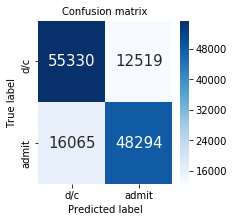

y_train distribution:  Counter({0: 67849, 1: 64359})

Validation Set


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.8363573878311584
AUROC:        0.8539441557183559
accuracy:     0.80176
precision:    [0.96524345 0.2820127 ]
recall:       [0.81039202 0.71848382]
sensitivity:  0.7184838160136287
specificity:  0.8103920183648243
PPV:          0.2820127047810097
NPV:          0.9652434535703018


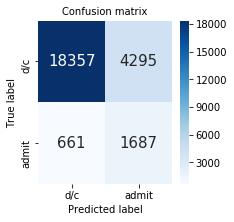

y_test distribution:  Counter({0: 22652, 1: 2348})

Training with 102128 examples

splitting into test and train sets:

performing augmentation now...
y_train baseline distribution:  Counter({0: 69254, 1: 7342})
ratio:  9
number of admitted patients:  7342
y_train augmented distribution:  Counter({0: 69254, 1: 66078})

number of admitted patients post augmentation:  66078

building and training model now...
CPU times: user 26min 6s, sys: 32 s, total: 26min 38s
Wall time: 27min 26s

Training Set


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.7824108332087346
AUROC:        0.8692616124330242
accuracy:     0.7827269234179647
precision:    [0.77272105 0.79446621]
recall:       [0.81518757 0.74870607]
sensitivity:  0.7487060746390629
specificity:  0.8151875703930459
PPV:          0.7944662127440905
NPV:          0.772721051190802


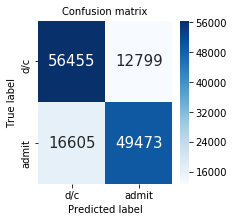

y_train distribution:  Counter({0: 69254, 1: 66078})

Validation Set


/Users/jjaskolkambp/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


Metrics Report:
---------------
weighted f1:  0.8408857897125573
AUROC:        0.8610276773799187
accuracy:     0.8069089769700768
precision:    [0.96737683 0.28521479]
recall:       [0.81481322 0.72893617]
sensitivity:  0.7289361702127659
specificity:  0.814813217151238
PPV:          0.2852147852147852
NPV:          0.9673768308921438


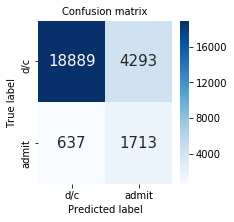

y_test distribution:  Counter({0: 23182, 1: 2350})


In [298]:
       
dataset_sizes = [100000, len(clin)]    

#initialize dataframe for results
col_names = ['num_examples','train_f1', 'test_f1', 'train_acc', 'test_acc', 'train_auroc', 'test_auroc', 'train_ppv', 'test_ppv', 'train_sens', 'test_sens']
output_df = pd.DataFrame(columns = col_names)

for size in dataset_sizes:
    print ()
    print ('Training with {} examples'.format(size))
    print ()
    
    print ('splitting into test and train sets:')
    X_train, X_test, y_train, y_test = train_test_split(all_features[:size], target[:size], random_state=1)
    
    print ('\nperforming augmentation now...')
    X_train, y_train = data_augmentation(X_train, y_train)
    
    print ('\nbuilding and training model now...')
    xgc = xgb.XGBClassifier(gamma = 0.5, reg_alpha = 0.5)
    %time xgc.fit(X_train, y_train)
    
    #random train subset for metrics
    #random_indices = np.random.choice(X_test.shape[0], len(X_test), replace=False)
    
    print ('\nTraining Set')
    train_f1, train_auroc, train_acc, train_sens, train_ppv = get_metrics(xgc, y_train, X_train,
                                                                          show_confusion = True, return_values = True)
    print ('y_train distribution: ', Counter(y_train))
    print ('\nValidation Set')
    test_f1, test_auroc, test_acc, test_sens, test_ppv = get_metrics(xgc, y_test, X_test,
                                                                     show_confusion = True, return_values = True)
    print ('y_test distribution: ', Counter(y_test))
    
    output_df.loc[len(output_df)] = [size,train_f1, test_f1, train_acc, test_acc, train_auroc, test_auroc, train_ppv, test_ppv, train_sens, test_sens]

In [297]:
output_df

,num_examples,train_f1,test_f1,train_acc,test_acc,train_auroc,test_auroc,train_ppv,test_ppv,train_sens,test_sens
0,1000.0,1.0,0.877406,1.0,0.9,1.0,0.743344,1.0,0.375,1.0,0.130435
